## **Generate random districts**

**Required packages**

In [10]:
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import MultiPolygon, Polygon, shape
from rasterio.features import rasterize
from rasterio.transform import from_bounds
from scipy.ndimage import distance_transform_edt, label, binary_dilation
import random
from matplotlib.colors import ListedColormap
from matplotlib.ticker import MaxNLocator
from IPython.display import clear_output
from shapely.ops import unary_union
from skimage.measure import find_contours

**Loading and Rasterizing Precinct Data**

In [2]:
# =======================
# Loading data
# =======================

precinct_shapefile = 'fl_2016/fl_2016.shp'
votes_gdf = gpd.read_file(precinct_shapefile)

# calculate votes (blue = democrat, red = republican)
votes_gdf['blue'] = votes_gdf['G16PREDCLI'] + votes_gdf['G16USSDMUR']  # Blue votes
votes_gdf['red'] = votes_gdf['G16PRERTRU'] + votes_gdf['G16USSRRUB']   # Red votes

# Reproject to a Projected CRS
votes_gdf_projected = votes_gdf.to_crs(epsg=3857)

# calculate area to get pop per pixel
votes_gdf_projected['area'] = votes_gdf_projected.geometry.area


# =======================
# Rasterizing
# =======================

# select columns to be rasterized
# (to calculate total votes per pixel)
selected_columns = ['blue', 'red']

# get coordinates
minx, miny, maxx, maxy = votes_gdf_projected.total_bounds
pixel_size = 6000  # Adjust pixel size as needed (in meters)
width = int(np.ceil((maxx - minx) / pixel_size))
height = int(np.ceil((maxy - miny) / pixel_size))
transform = from_bounds(minx, miny, maxx, maxy, width, height)

# rasterize attributes
raster_bands = []
for col in selected_columns:
    # Create shapes for rasterization with scaled values
    shapes = (
        (geom, value)
        for geom, value in zip(votes_gdf_projected.geometry, votes_gdf_projected[col])
    )
    raster_band = rasterize(
        shapes=shapes,
        out_shape=(height, width),
        transform=transform,
        fill=0,
        dtype='float32'
    )
    raster_bands.append(raster_band)

blue_band, red_band = raster_bands

# total votes/population per pixel
population = blue_band + red_band 

# =======================
# Florida mask
# this part ignores pixels that are not within Florida
# =======================

# get the boundary of Florida state
florida_union = votes_gdf_projected.union_all()

# Ensure the union is a Polygon or MultiPolygon
if not isinstance(florida_union, (Polygon, MultiPolygon)):
    raise ValueError("Unexpected geometry type for unary_union. Expected Polygon or MultiPolygon.")

# Rasterize the Florida boundary to create a mask
florida_mask = rasterize(
    [(florida_union, 1)], # 1 is pixel is inside, 0 otherwise
    out_shape=(height, width),
    transform=transform,
    fill=0,
    dtype='uint8'
)

# Apply the Florida mask to the population array
# Pixels outside Florida will have population = 0
population_masked = population * florida_mask

**Voronoi Districts Function**

In [3]:
def generate_voronoi_districts(population_masked, num_districts=27, random_seed=None):
    """
    Generates Voronoi-based districts within Florida based on a population raster.

    Parameters:
        population_masked (np.ndarray): 2D array representing population per pixel within Florida.
        num_districts (int): Number of districts to generate. Default is 27.
        tolerance (float): Population tolerance (unused in Voronoi, but kept for reference). Default is 50000.
        random_seed (int, optional): Seed for random number generator for reproducibility.

    Returns:
        district_map (np.ndarray): 2D array with district IDs assigned to each pixel. Pixels outside Florida are -1.
        seed_coords (np.ndarray): Array of shape (num_districts, 2) with seed pixel coordinates (row, column).
        target_pop (float): Target population per district.
    """
    # specify seed for reproducibility
    if random_seed is not None:
        random.seed(random_seed)
        np.random.seed(random_seed)

    # Calculate total and target population
    total_pop = population_masked.sum()
    target_pop = total_pop / num_districts
    # print("Total population within Florida:", total_pop)
    # print("Target population per district:", target_pop)

    # =======================
    # Voronoi Tesselation
    # =======================

    # get pixels within Florida
    valid_pixels = np.argwhere(population_masked > 0)
    if len(valid_pixels) < num_districts:
        raise ValueError("Not enough valid pixels to assign to districts.")

    # randomly sample 27 pixels (one for each district)
    seed_indices = random.sample(range(valid_pixels.shape[0]), num_districts)
    seed_coords = valid_pixels[seed_indices]

    # create an empty district map
    # initialize with -1 for ocean pixels (outside Florida)
    height, width = population_masked.shape
    district_map = -1 * np.ones((height, width), dtype=int)

    # assign each sampled pixel to a district
    for d_id, (r, c) in enumerate(seed_coords):
        district_map[r, c] = d_id

    # compute Voronoi Tessellation
    # Create a boolean array where seed pixels are True
    seed_mask = np.zeros((height, width), dtype=bool)
    seed_mask[seed_coords[:, 0], seed_coords[:, 1]] = True

    # find the nearest pixel to each sampled pixel
    distance, indices = distance_transform_edt(~seed_mask, return_indices=True)

    # assign each pixel to the nearest seed's district ID
    nearest_row = indices[0]
    nearest_col = indices[1]
    nearest_district = district_map[nearest_row, nearest_col]

    # update the district map for all valid pixels
    district_map[population_masked > 0] = nearest_district[population_masked > 0]

    # =======================
    # Calculate Population and Vote Percentages
    # =======================

    # Initialize lists to store data for each district
    district_ids = range(num_districts)
    total_population = []
    total_blue = []
    total_red = []
    percentage_blue = []
    percentage_red = []

    # create data frame with population and votes per district
    # ---------------------------------------

    for d_id in district_ids:
        # Create a mask for the current district
        mask = (district_map == d_id)
        
        # Calculate total population for the district
        pop = population_masked[mask].sum()
        total_population.append(pop)
        
        # Calculate total blue and red votes for the district
        blue = blue_band[mask].sum()
        red = red_band[mask].sum()
        total_blue.append(blue)
        total_red.append(red)
        
        # Calculate percentage of blue and red votes
        if pop > 0:
            percentage_blue.append((blue / pop) * 100.0)
            percentage_red.append((red / pop) * 100.0)
        else:
            percentage_blue.append(0)
            percentage_red.append(0)
    
    # ---------------------------------------

    data = {
        'District': district_ids,
        'Total Population': total_population,
        'Blue Votes': total_blue,
        'Red Votes': total_red,
        'Percentage Blue': percentage_blue,
        'Percentage Red': percentage_red
    }

    df = pd.DataFrame(data)

    # =======================
    # Plots:
    # =======================

    #  Voronoi Districts
    # ------------------------
    district_colors = plt.get_cmap('tab20', num_districts).colors[:num_districts]
    colors = list(district_colors) + [(0, 0, 0, 1)]  # Adding black for ocean
    custom_cmap = ListedColormap(colors)

    # Adjust district_map to Shift -1 to the Last Index (for black color)
    district_map_shifted = district_map.copy()
    district_map_shifted[district_map_shifted == -1] = num_districts  # Assign -1 to black

    # Combine all plots in 1 row, 3 columns
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot 1
    im = axes[0].imshow(
        district_map_shifted,
        cmap=custom_cmap,
        interpolation='nearest',
        origin='upper',
        extent=(minx, maxx, miny, maxy)
    )
    axes[0].grid(False)
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[0].set_title("Voronoi Districts", fontsize=14)

    # Population and Votes per District
    # ------------------------
    # Plot 2: Total Population per District
    axes[1].bar(df['District'], df['Total Population'], color='lightgreen')
    axes[1].set_xlabel('District ID', fontsize=12)
    axes[1].set_ylabel('Total Population', fontsize=12)
    axes[1].set_title('Total Population per District', fontsize=14)
    axes[1].grid(axis='y', linestyle='--', alpha=0.7)

    # Plot 3: Percentage of Blue vs Red Votes per District
    width = 0.6  # Width of the bars
    axes[2].bar(df['District'], df['Percentage Blue'], width, label='Blue', color='skyblue')
    axes[2].bar(df['District'], df['Percentage Red'], width, bottom=df['Percentage Blue'], label='Red', color='pink')
    axes[2].set_xlabel('District ID', fontsize=12)
    axes[2].set_ylabel('Percentage of Votes (%)', fontsize=12)
    axes[2].set_title('Percentage of Blue vs Red Votes', fontsize=14)
    axes[2].legend(fontsize=10)
    axes[2].grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

    # =======================
    
    return district_map, seed_coords, target_pop


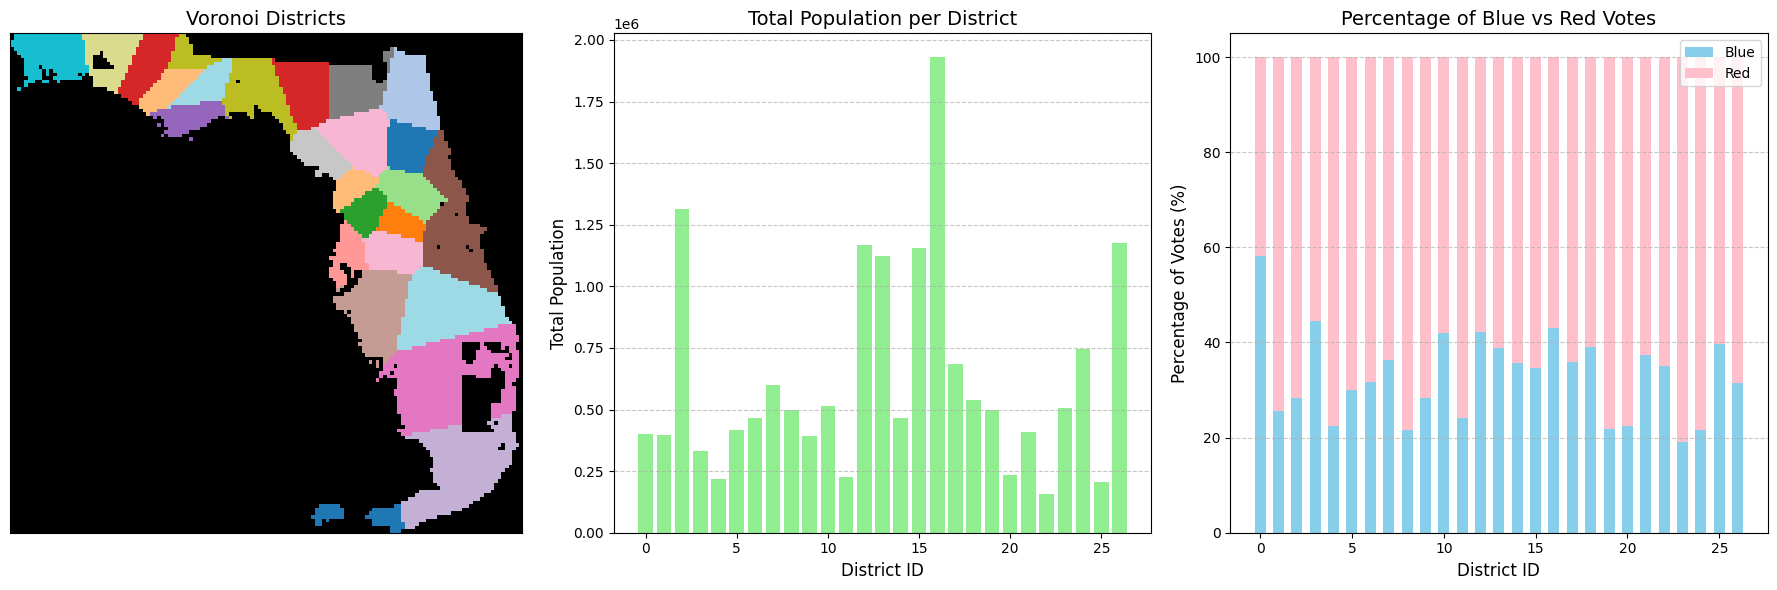

In [4]:
district_map, seed_coords, target_pop = generate_voronoi_districts(population_masked, 27)

# **Proposed Algorithm Implementation**

In [5]:
def enforce_largest_connected_component(district_map):
    """
    Enforce contiguity by retaining only the largest connected component
    across the entire district map, removing all other smaller components.

    Parameters:
        district_map (np.ndarray): 2D array with district IDs (>= 0) and -1 for outside areas.

    Returns:
        np.ndarray: Updated district map with only the largest connected component retained.
    """
    # Mask to ignore ocean/outside (-1)
    valid_mask = district_map >= 0

    # Label connected components across the entire map
    labeled, num_components = label(valid_mask)

    if num_components <= 1:
        return district_map  # Already one connected component

    # Find the largest connected component
    component_sizes = [(comp_label, np.sum(labeled == comp_label)) for comp_label in range(1, num_components + 1)]
    largest_label = max(component_sizes, key=lambda x: x[1])[0]  # Find label with the largest size

    # Create a mask for the largest connected component
    largest_component_mask = (labeled == largest_label)

    # Set all other regions to -1 (outside)
    district_map[~largest_component_mask] = -1

    return district_map

In [6]:
 # Example usage
district_map = enforce_largest_connected_component(district_map)

In [12]:
def plot_district_map_with_population_interactive(
    district_map,
    population_masked,
    num_districts,
    iteration=None,
    population_losses=None,
    compactness_losses=None,
    total_losses=None,
    temperatures=None,
):
    """
    Dynamically visualize the district map, population chart, and loss curves in an interactive manner.

    Parameters:
        district_map (np.ndarray): 2D array of districts.
        population_masked (np.ndarray): 2D array of population values per pixel.
        num_districts (int): Total number of districts.
        iteration (int, optional): Current iteration number to include in the plot title.
        population_losses (list, optional): List of population losses over iterations.
        compactness_losses (list, optional): List of compactness losses over iterations.
        total_losses (list, optional): List of total losses over iterations.
        temperatures (list, optional): List of temperatures over iterations.
    """
    from IPython.display import display, clear_output

    # Clear the current output in Jupyter or console
    clear_output(wait=True)

    # Calculate population per district
    district_ids = range(num_districts)
    total_population = []
    for d_id in district_ids:
        mask = (district_map == d_id)
        pop = population_masked[mask].sum()
        total_population.append(pop)

    # Create colormap for districts
    district_colors = plt.get_cmap('tab20', num_districts).colors[:num_districts]
    custom_colors = list(district_colors) + [(0, 0, 0, 1)]  # Black for -1
    custom_cmap = ListedColormap(custom_colors)

    # Shift -1 to the last index
    district_map_shifted = district_map.copy()
    district_map_shifted[district_map_shifted == -1] = num_districts

    # Initialize figure with 3 rows for map, population, and losses
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))

    # Plot district map
    axes[0].imshow(
        district_map_shifted,
        cmap=custom_cmap,
        interpolation='nearest',
        origin='upper'
    )
    axes[0].set_title("District Map" + (f" - Iteration {iteration}" if iteration is not None else ""))
    axes[0].set_xticks([])
    axes[0].set_yticks([])

    # Plot population bar chart
    axes[1].bar(district_ids, total_population, color='lightblue')
    axes[1].set_xlabel('District ID', fontsize=12)
    axes[1].set_ylabel('Total Population', fontsize=12)
    axes[1].set_title('Population per District', fontsize=14)
    axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
    axes[1].grid(axis='y', linestyle='--', alpha=0.7)

    # Plot loss and temperature curves
    if population_losses and compactness_losses and total_losses and temperatures:
        axes[2].plot(population_losses, label="Population Loss", color="blue")
        axes[2].plot(compactness_losses, label="Compactness Loss", color="green")
        axes[2].plot(total_losses, label="Total Loss", color="red")
        #axes[2].plot(temperatures, label="Temperature", color="orange")
        axes[2].set_title("Loss and Temperature Over Iterations", fontsize=14)
        axes[2].set_xlabel("Iteration", fontsize=12)
        axes[2].set_ylabel("Loss / Temperature", fontsize=12)
        axes[2].legend()
        axes[2].grid(axis='y', linestyle='--', alpha=0.7)

    # Adjust layout
    plt.tight_layout()

    # Display and pause for updates
    display(fig)
    plt.pause(0.1)
    plt.close(fig)  # Ensure the figure is cleared after each display

In [ ]:
def calculate_loss(district_map, pop_dict, target_pop, alpha, beta):
    """
    Calculate the combined loss (population imbalance + compactness) and return each component.

    Parameters:
        district_map (np.ndarray): 2D array of districts.
        pop_dict (dict): Population of each district.
        target_pop (float): Target population per district.
        alpha (float): Weight for compactness.
        beta (float): Weight for population imbalance.

    Returns:
        tuple: Population imbalance, compactness score, and combined loss.
    """
    # Population imbalance
    pop_imbalance = sum((pop - target_pop) ** 2 for pop in pop_dict.values())
    weighted_pop_imbalance = beta * pop_imbalance

    # Compactness
    compactness_score = sum(
        calculate_compactness(district_map, d_id) for d_id in np.unique(district_map) if d_id >= 0
    )
    weighted_compactness = alpha * compactness_score

    # Combined loss
    total_loss = weighted_pop_imbalance + weighted_compactness

    return weighted_pop_imbalance, weighted_compactness, total_loss


def calculate_district_populations(district_map, population_masked):
    # sum population of each district
    unique_districts = np.unique(district_map)
    unique_districts = unique_districts[unique_districts >= 0]
    pop_dict = {}
    for d_id in unique_districts:
        pop_dict[d_id] = population_masked[district_map == d_id].sum()
    return pop_dict


def get_border_pixels(district_map):
    """
    Identify border pixels of districts. A border pixel is one that is part of a district
    but is adjacent to a pixel of a different district or -1.
    """
    neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    height, width = district_map.shape
    border_pixels = []

    for r in range(height):
        for c in range(width):
            d_id = district_map[r, c]
            if d_id < 0:  # Skip outside regions
                continue
            # Check neighbors
            for dr, dc in neighbors:
                nr, nc = r + dr, c + dc
                if 0 <= nr < height and 0 <= nc < width:
                    if district_map[nr, nc] != d_id:  # Different district or -1
                        border_pixels.append((r, c))
                        break
    return border_pixels


def calculate_compactness(district_map, district_id):
    """
    Calculate the compactness (perimeter-to-area ratio) of a district.

    Parameters:
        district_map (np.ndarray): 2D array of district IDs.
        district_id (int): ID of the district to evaluate.

    Returns:
        float: Compactness score (lower is better).
    """
    # Create a mask for the district
    district_mask = (district_map == district_id)
    if not district_mask.any():  # Skip if the district does not exist
        return float('inf')

    # Find the contours of the district
    contours = find_contours(district_mask.astype(int), 0.5)
    if not contours:
        return float('inf')  # No valid contours

    # Create polygons from contours
    polygons = []
    for contour in contours:
        if len(contour) > 2:  # Ensure at least 3 points
            poly = Polygon(contour)
            if poly.is_valid and poly.area > 0:  # Filter invalid or zero-area polygons
                polygons.append(poly)

    if not polygons:
        return float('inf')  # No valid polygons

    # Union all regions to form the full district geometry
    try:
        district_polygon = unary_union(polygons)
    except Exception as e:
        print(f"Error during union operation: {e}")
        return float('inf')

    # Calculate compactness = Perimeter / sqrt(Area)
    perimeter = district_polygon.length
    area = district_polygon.area
    if area == 0:
        return float('inf')  # Avoid division by zero

    return perimeter / (area ** 0.5)


def is_contiguous_after_flip(district_map, current_d, r, c):
    """
    Check if the district `current_d` remains contiguous after removing the pixel `(r, c)`.

    Parameters:
        district_map (np.ndarray): 2D array of districts.
        current_d (int): District ID of the pixel being removed.
        r (int): Row index of the pixel to remove.
        c (int): Column index of the pixel to remove.

    Returns:
        bool: True if the district remains contiguous, False otherwise.
    """
    district_mask = (district_map == current_d)
    labeled, num_components = label(district_mask)

    # Create a temporary mask for the current district
    district_mask = (district_map == current_d)

    # Remove the pixel (r, c) from the district mask
    district_mask[r, c] = False

    # Check connected components in the modified district mask
    labeled2, num_components2 = label(district_mask)

    # If there is more than one component, the district is disconnected
    return num_components2 == num_components


def evaluate_flip_and_loss_optimized(district_map, population_masked, pop_dict, pixel, target_pop, alpha, beta, current_loss):
    """
    Evaluate flipping a border pixel and calculate the resulting loss efficiently.

    Parameters:
        current_loss (tuple): The current loss values (population loss, compactness loss, total loss).

    Returns:
        tuple: Best new district ID, change in total loss, and updated loss values (population, compactness, total).
    """
    r, c = pixel
    current_d = district_map[r, c]

    # Identify candidate new districts from neighbors
    neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    height, width = district_map.shape
    candidate_districts = set()
    for dr, dc in neighbors:
        nr, nc = r + dr, c + dc
        if 0 <= nr < height and 0 <= nc < width:
            if district_map[nr, nc] >= 0 and district_map[nr, nc] != current_d:
                candidate_districts.add(district_map[nr, nc])
    if not candidate_districts:
        return None, None, current_loss  # No valid flip

    # Extract current losses
    current_pop_loss, current_compact_loss, current_total_loss = current_loss

    best_new_d = None
    best_delta_loss = float("inf")  # Ensure this is a scalar
    best_new_loss = current_loss

    pixel_pop = population_masked[r, c]

    for new_d in candidate_districts:
        # Check contiguity before simulating the flip
        if not is_contiguous_after_flip(district_map, current_d, r, c):
            continue  # Skip this flip as it would disconnect the current district

        # Simulate the flip temporarily
        pop_dict_new = pop_dict.copy()
        pop_dict_new[current_d] -= pixel_pop
        pop_dict_new[new_d] += pixel_pop

        # Incrementally update population loss
        new_pop_loss = current_pop_loss - beta * ((pop_dict[current_d] - target_pop) ** 2)
        new_pop_loss -= beta * ((pop_dict[new_d] - target_pop) ** 2)
        new_pop_loss += beta * ((pop_dict_new[current_d] - target_pop) ** 2)
        new_pop_loss += beta * ((pop_dict_new[new_d] - target_pop) ** 2)

        # Temporarily update the district map
        new_compact_loss = current_compact_loss

        new_compact_loss -= alpha * calculate_compactness(district_map, current_d)
        new_compact_loss -= alpha * calculate_compactness(district_map, new_d)
        
        district_map[r, c] = new_d


        current_d_compact = calculate_compactness(district_map, current_d)
        new_d_compact = calculate_compactness(district_map, new_d)

        new_compact_loss += alpha * current_d_compact
        new_compact_loss += alpha * new_d_compact

        # Revert the district map after evaluation
        district_map[r, c] = current_d

        # Calculate total loss
        new_total_loss = new_pop_loss + new_compact_loss
        delta_loss = float(new_total_loss - current_total_loss)  # Ensure delta_loss is scalar

        if delta_loss < best_delta_loss:  # Compare scalars
            best_delta_loss = delta_loss
            best_new_d = new_d
            best_new_loss = (new_pop_loss, new_compact_loss, new_total_loss)

    return best_new_d, best_delta_loss, best_new_loss


def flip_pixel(district_map, pop_dict, pixel, new_d, population_masked):
    """
    Perform the flip of a pixel to a new district and update the population dictionary.
    """
    r, c = pixel
    old_d = district_map[r, c]
    pixel_pop = population_masked[r, c]

    # Update district_map
    district_map[r, c] = new_d

    # Update population dictionary
    pop_dict[old_d] -= pixel_pop
    pop_dict[new_d] += pixel_pop

    return district_map, pop_dict



In [14]:
def flip_district_map_with_loss_optimized(
    district_map,
    population_masked,
    num_iterations,
    target_pop,
    initial_temp,
    cooling_rate,
    num_districts,
    alpha=200,
    beta=0.00000001,
    visualize_every=200,
):
    """
    Iteratively flip border pixels to optimize combined loss with fewer loss calculations.

    Parameters:
        current_loss (tuple): The current loss values (population loss, compactness loss, total loss).

    Returns:
        np.ndarray: Updated district map.
    """
    pop_dict = calculate_district_populations(district_map, population_masked)
    temp = initial_temp

    # Initialize losses and temperature for visualization
    population_losses = []
    compactness_losses = []
    total_losses = []
    temperatures = []

    # Calculate initial loss
    current_loss = calculate_loss(district_map, pop_dict, target_pop, alpha, beta)

    for iteration in range(num_iterations):
        # Get border pixels
        border_pixels = get_border_pixels(district_map)
        if not border_pixels:
            print(f"No border pixels left at iteration {iteration}. Exiting.")
            break

        # Randomly select a border pixel
        pixel = random.choice(border_pixels)

        # Evaluate the flip and calculate the loss
        new_d, delta_loss, new_loss = evaluate_flip_and_loss_optimized(
            district_map, population_masked, pop_dict, pixel, target_pop, alpha, beta, current_loss
        )
        if new_d is None:
            continue  # No valid flips

        # Apply simulated annealing acceptance criterion
        if delta_loss < 0 or np.random.rand() < np.exp(-delta_loss / temp):
            # Perform the flip
            district_map, pop_dict = flip_pixel(district_map, pop_dict, pixel, new_d, population_masked)
            current_loss = new_loss  # Update current loss

        # Decrease the temperature
        temp *= cooling_rate

        # Store losses for visualization
        pop_loss, compact_loss, total_loss = current_loss
        population_losses.append(pop_loss)
        compactness_losses.append(compact_loss)
        total_losses.append(total_loss)
        temperatures.append(temp)
        print(compact_loss)

        # Visualize periodically
        if visualize_every > 0 and iteration % visualize_every == 0:
            plot_district_map_with_population_interactive(
                district_map,
                population_masked,
                num_districts,
                iteration=iteration + 1,
                population_losses=population_losses,
                compactness_losses=compactness_losses,
                total_losses=total_losses,
                temperatures=temperatures,
            )

    # Final visualization
    plot_district_map_with_population_interactive(
        district_map,
        population_masked,
        num_districts,
        iteration=num_iterations,
        population_losses=population_losses,
        compactness_losses=compactness_losses,
        total_losses=total_losses,
        temperatures=temperatures,
    )

    return district_map

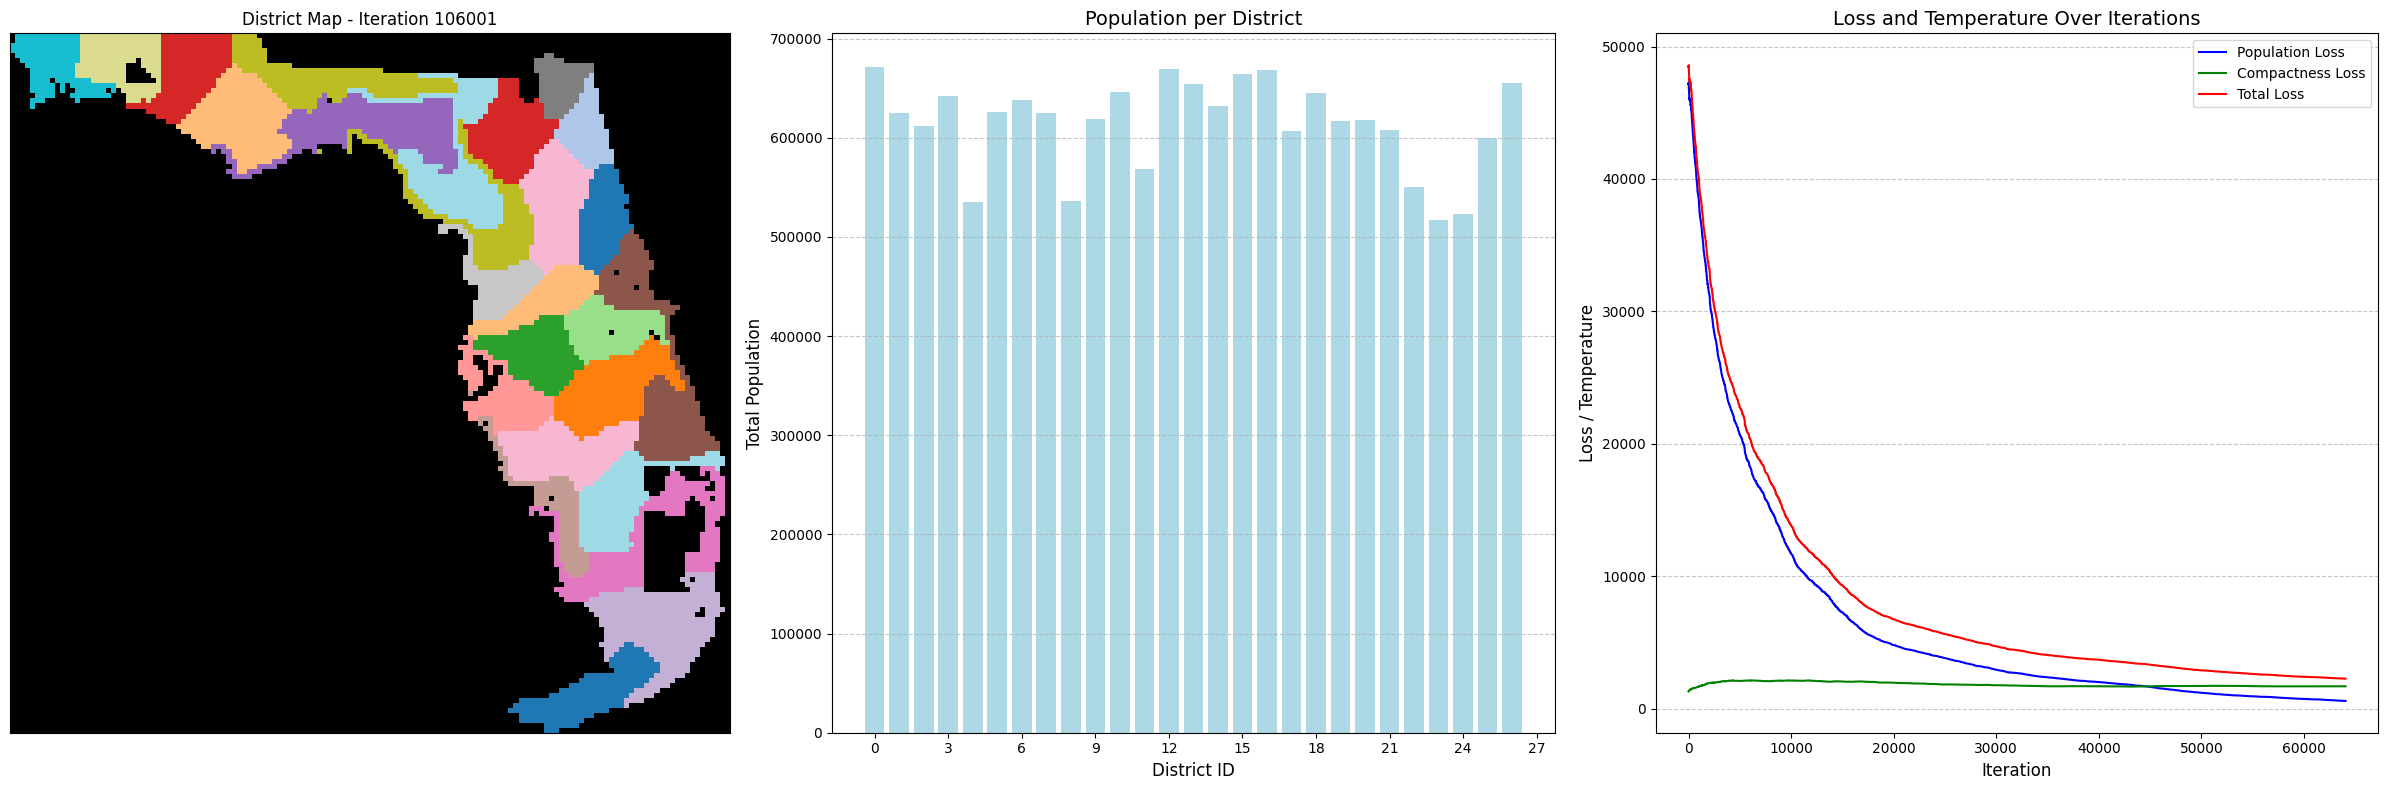

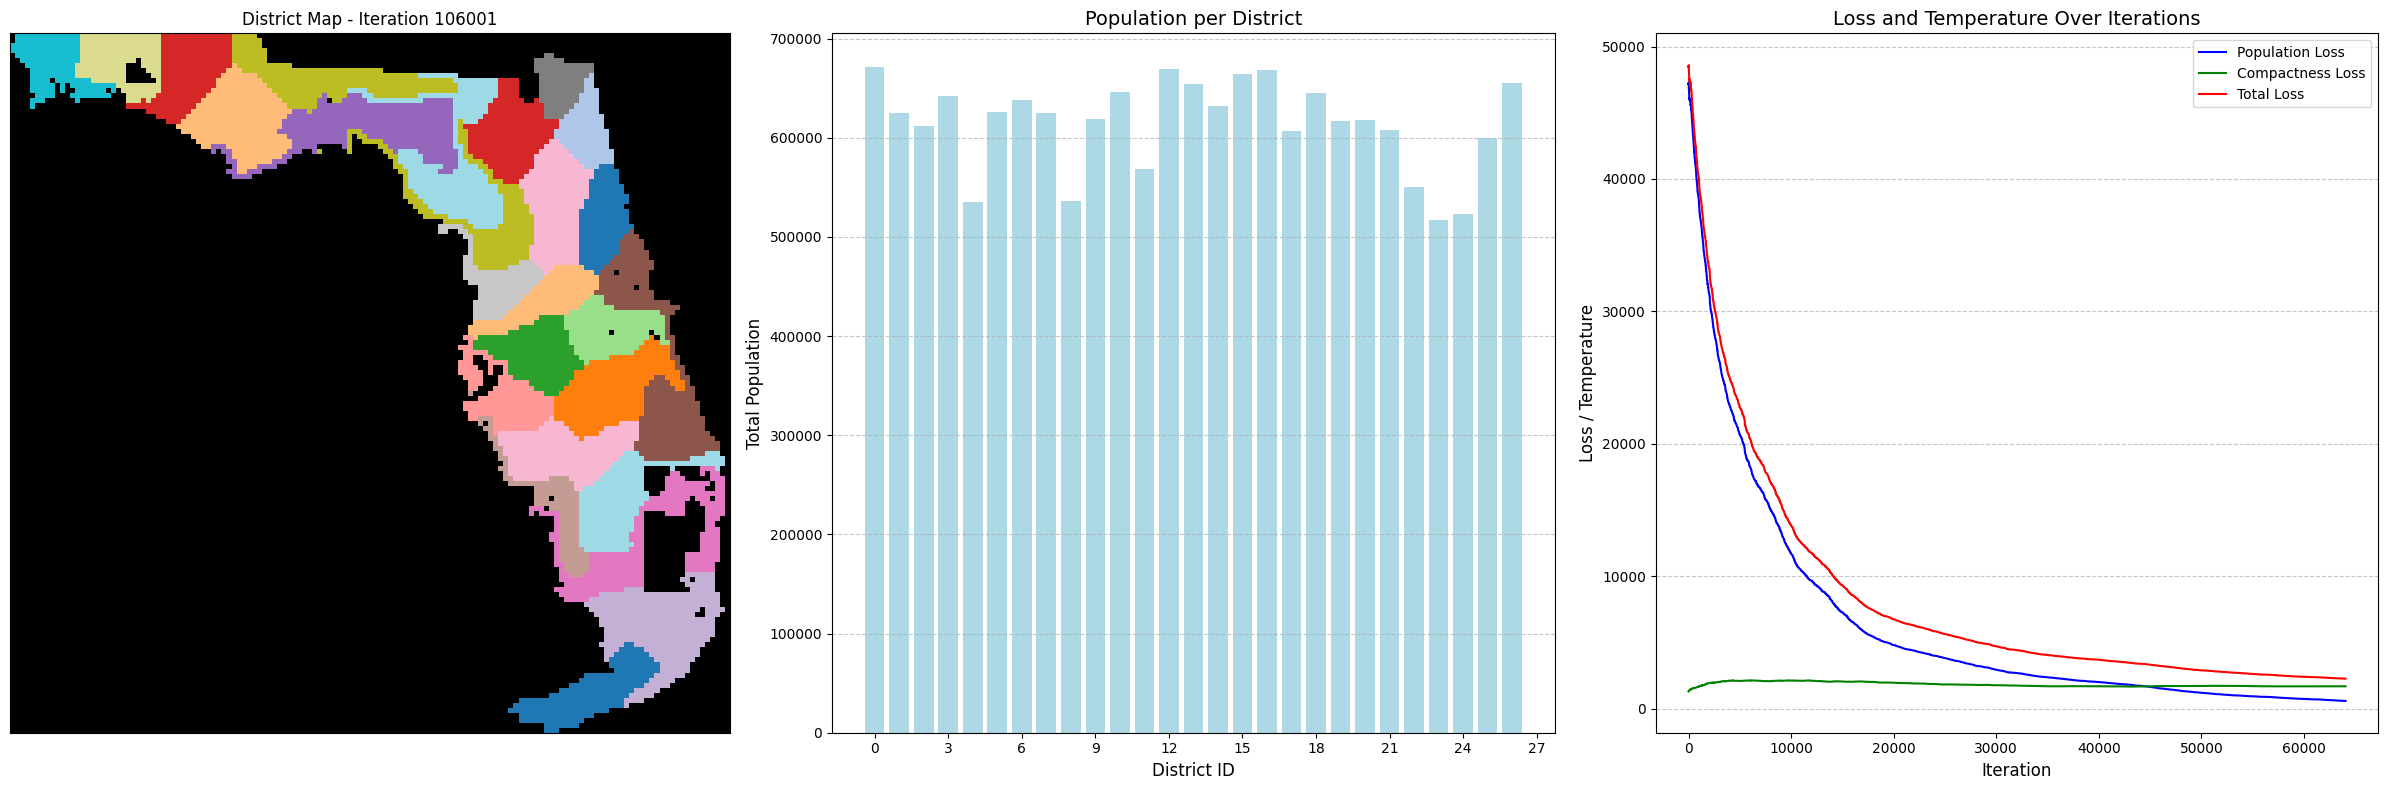

1678.4298883202398
1678.4298883202398
1678.4298883202398
1678.4298883202398
1678.4298883202398
1678.4298883202398
1678.4298883202398
1678.4298883202398
1678.4298883202398
1678.4298883202398
1678.4298883202398
1678.4298883202398
1678.4298883202398
1678.4298883202398
1678.4298883202398
1678.4298883202398
1678.4298883202398
1678.4298883202398
1678.4298883202398
1678.4298883202398
1678.4298883202398
1678.4298883202398
1678.4298883202398
1678.4298883202398
1678.4298883202398
1678.4298883202398
1678.4298883202398
1678.4298883202398
1678.4298883202398
1678.4298883202398
1678.4298883202398
1678.4298883202398
1678.4298883202398
1678.4298883202398
1678.4298883202398
1678.4298883202398
1678.4298883202398
1678.4298883202398
1678.4298883202398
1678.4298883202398
1678.4298883202398
1678.4298883202398
1678.4298883202398
1678.4298883202398
1679.2817644535733
1679.2817644535733
1679.2817644535733
1679.2817644535733
1679.2817644535733
1679.2817644535733
1679.2817644535733
1679.2817644535733
1679.2817644

KeyboardInterrupt: 

In [13]:
# Example Usage
num_districts = 27
total_population = population_masked.sum()
target_pop = total_population / num_districts

# Flip the district map with visualization
district_map = flip_district_map_with_loss_optimized(
    district_map=district_map,
    population_masked=population_masked,
    num_iterations=1000000,
    target_pop=target_pop,
    initial_temp=100,
    cooling_rate=0.99,
    num_districts = 27,
    alpha=10,  # Compactness weight
    beta=0.00000001,  # Population imbalance weight
    visualize_every=500  # Update visualization every 200 iterations
)